# CREDIT CARD FRAUD DETECTION USING SUPERVISED MACHINE LEARNING AND GENETIC ALGORITHM FEATURE SELECTION​

# Import Libraries

In [3]:
%pip install category_encoders

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler # Import StandardScaler

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

sns.set_style('whitegrid') # sets the visual style of Seaborn plots to 'whitegrid', which displays a white background with grid lines.
sns.set_palette('pastel')  # sets the color palette to 'pastel', which is one of the predefined color palettes provided by Seaborn. It consists of a set of visually distinct colors suitable for plotting categorical data.

import warnings
# Ignore all warnings
warnings.simplefilter("ignore")

# --- new additions for GA ---
!pip -q install pygad imbalanced-learn xgboost==1.7.6
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, ConfusionMatrixDisplay
import pygad
from pathlib import Path

# Load Data

In [4]:
train_df = pd.read_csv('train.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('test.csv', index_col='Unnamed: 0')

## Feature Engineering

In [5]:
#Change date type from obj to datetime
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'],format='mixed')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'],format='mixed')

In [6]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
992821,2020-02-09 19:56:03,2242542703101233,fraud_Schumm PLC,shopping_net,2.38,Samuel,Jenkins,M,43235 Mckenzie Views Apt. 837,Westport,...,564,Pensions consultant,1996-04-10,b20aa993023080f7df3445917fc2c529,1360439763,38.238540,-85.331889,0,19,2
833489,2019-12-11 20:10:09,213157767990030,"fraud_Okuneva, Schneider and Rau",shopping_pos,6.53,Tara,Campbell,F,05050 Rogers Well Apt. 439,Rock Springs,...,27971,Music therapist,1984-08-01,699d832d45640a873dc40a78f7197f3f,1355256609,42.402782,-109.452891,0,20,12
517107,2019-08-11 16:59:48,6544734391390261,"fraud_Zboncak, Rowe and Murazik",shopping_net,6.62,John,Myers,M,701 Wilson Divide,Highland,...,23727,Community arts worker,1982-02-08,dfda609e0a608c46084aa260d24fc9b3,1344704388,41.876220,-88.320794,0,16,8
166051,2019-03-29 08:21:13,4635330563105903,"fraud_Bernier, Volkman and Hoeger",misc_net,24.86,Christina,Rose,F,1984 Taylor Island Suite 836,Falls Church,...,116155,Chartered accountant,1983-07-10,09863670cadcdcf7637e5fff4947fe82,1333009273,38.780532,-77.549100,0,8,3
473161,2019-07-27 14:47:05,213141712584544,"fraud_Prosacco, Kreiger and Kovacek",home,25.65,Margaret,Curtis,F,742 Oneill Shore,Florence,...,19685,Fine artist,1984-12-24,8304d76b2d85934b72c39a7624d444bb,1343400425,32.376997,-89.326699,0,14,7


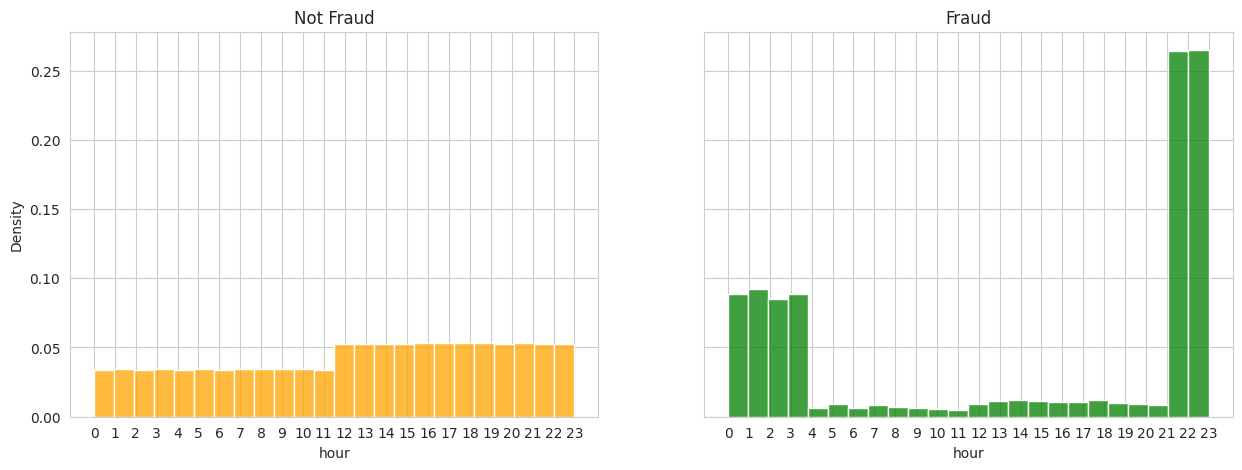

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

# Data Preprocessing

In [8]:
unique_transaction_count = len(train_df['trans_num'].unique())
print("Total count of unique transaction numbers:", unique_transaction_count)

Total count of unique transaction numbers: 907672


In [9]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
992821,fraud_Schumm PLC,shopping_net,2.38,Jenkins,M,38.4921,-85.4524,564,Pensions consultant,38.238540,-85.331889,0,19,2
833489,"fraud_Okuneva, Schneider and Rau",shopping_pos,6.53,Campbell,F,41.6060,-109.2300,27971,Music therapist,42.402782,-109.452891,0,20,12


In [10]:
#clean merchant column
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))
test_df['merchant'] = test_df['merchant'].apply(lambda x : x.replace('fraud_',''))

# Data Encoding

Down-Sampling and Scaling

In [29]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# -----------------------------
# 1. Remove missing values
# -----------------------------
train_df = train_df.dropna()

# -----------------------------
# 2. Remove outliers in 'amt'
# -----------------------------
# clip extreme values instead of removing rows
train_df = train_df[(train_df['amt'] >= 5) & (train_df['amt'] <= 1250)]

# -----------------------------
# 3. Under-sampling (as in paper)
# -----------------------------
No_class = train_df[train_df["is_fraud"] == 0]
yes_class = train_df[train_df["is_fraud"] == 1]

No_class = resample(No_class, replace=False, n_samples=len(yes_class), random_state=42)
down_samples = pd.concat([yes_class, No_class], axis=0)

# -----------------------------
# 4. Drop unneeded columns
# -----------------------------
columns_to_drop = ['first','unix_time','dob','cc_num','zip','city','street','state','trans_num','trans_date_trans_time']
down_samples = down_samples.drop(columns=columns_to_drop, axis=1, errors='ignore')

# -----------------------------
# 5. Encode categorical columns
# -----------------------------
# Identify object/string columns
cat_cols = down_samples.select_dtypes(include=['object']).columns

# Apply Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    down_samples[col] = le.fit_transform(down_samples[col].astype(str))

# -----------------------------
# 6. Split X and y
# -----------------------------
X = down_samples.drop("is_fraud", axis=1)
y = down_samples["is_fraud"]

# -----------------------------
# 7. Min-Max Scaling (0–1)
# -----------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# 8. Train/test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=65, stratify=y
)

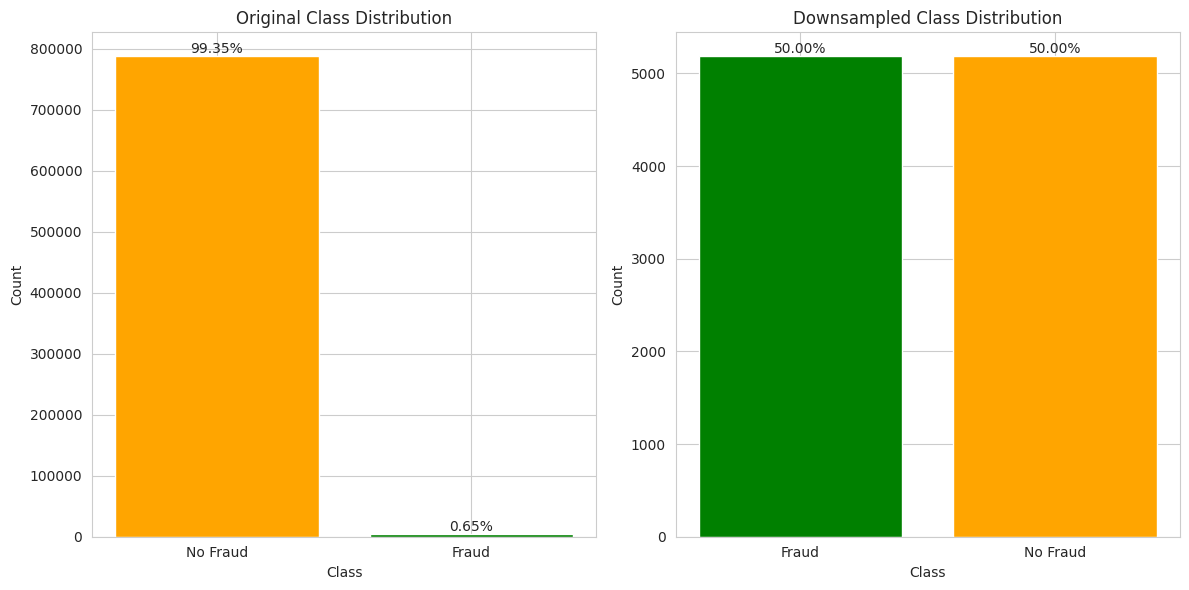

In [30]:
# Count the occurrences of each class in the original dataset
original_class_counts = train_df["is_fraud"].value_counts()

# Count the occurrences of each class in the downsampled dataset
downsampled_class_counts = down_samples["is_fraud"].value_counts()

# Calculate the percentage of each class
original_percentages = original_class_counts / len(train_df) * 100
downsampled_percentages = downsampled_class_counts / len(down_samples) * 100

# Plotting
plt.figure(figsize=(12, 6))

# Bar chart for original class distribution
plt.subplot(1, 2, 1)
bars_1 = plt.bar(original_class_counts.index, original_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_1, original_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(original_class_counts.index, ['No Fraud', 'Fraud'])

# Bar chart for downsampled class distribution
plt.subplot(1, 2, 2)
bars_2 = plt.bar(downsampled_class_counts.index, downsampled_class_counts.values, color=['orange', 'green'])
for bar, label in zip(bars_2, downsampled_percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{label:.2f}%', ha='center', va='bottom')
plt.title('Downsampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(downsampled_class_counts.index, ['No Fraud', 'Fraud'])

plt.tight_layout() # the plots will be automatically adjusted to ensure that there is no overlap between subplots and that all elements are clearly visible.
plt.show()

# MODEL TRAINING

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, f1_score, average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np

# ---------- Helper: evaluation with plots + threshold tuning ----------
def evaluate_model_with_plots(model, X_test, y_test, name="Model", tune_threshold=True):
    """
    Train is already done. This function:
      - computes ROC-AUC, PR-AUC, Avg Precision
      - optionally tunes threshold for best F1
      - prints classification report
      - shows confusion matrices + ROC + PR curves
    """
    # Probabilities and default predictions
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_default = (y_proba >= 0.5).astype(int)

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    # PR-AUC
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)
    ap = average_precision_score(y_test, y_proba)

    print(f"\n===== {name} =====")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-AUC:  {pr_auc:.4f}")
    print(f"Avg Precision (AP): {ap:.4f}")

    # Threshold tuning by F1
    best_thr = 0.5
    best_f1 = f1_score(y_test, y_pred_default)

    if tune_threshold:
        for thr in np.linspace(0.05, 0.95, 19):
            y_pred_thr = (y_proba >= thr).astype(int)
            f1 = f1_score(y_test, y_pred_thr)
            if f1 > best_f1:
                best_f1 = f1
                best_thr = thr

    print(f"Best threshold (by F1): {best_thr:.2f}")
    y_pred = (y_proba >= best_thr).astype(int)

    # Classification report
    print("Classification report at best threshold:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix (raw)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix (raw counts):\n", cm)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Not Fraud", "Fraud"])
    disp.plot(values_format='d')
    plt.title(f"{name} - Confusion Matrix (thr={best_thr:.2f})")
    plt.show()

    # Normalized confusion matrix
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    disp_norm = ConfusionMatrixDisplay(cm_norm, display_labels=["Not Fraud", "Fraud"])
    disp_norm.plot(values_format='.2f')
    plt.title(f"{name} - Normalized Confusion Matrix (thr={best_thr:.2f})")
    plt.show()

    # ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()

    # PR curve
    plt.plot(rec, prec, label=f'{name} (PR AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend()
    plt.show()

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "avg_precision": ap,
        "best_threshold": best_thr,
        "best_f1": best_f1
    }

## Logisitic Regression


===== Logistic Regression =====
ROC-AUC: 0.8377
PR-AUC:  0.8863
Avg Precision (AP): 0.8864
Best threshold (by F1): 0.60
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.79      0.95      0.87      1037
           1       0.94      0.75      0.84      1037

    accuracy                           0.85      2074
   macro avg       0.87      0.85      0.85      2074
weighted avg       0.87      0.85      0.85      2074

Confusion matrix (raw counts):
 [[987  50]
 [256 781]]


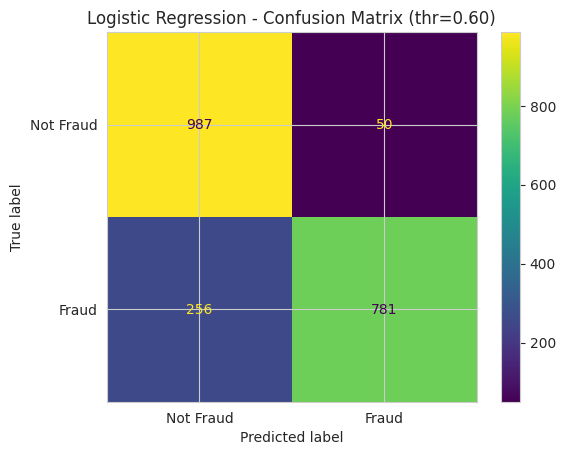

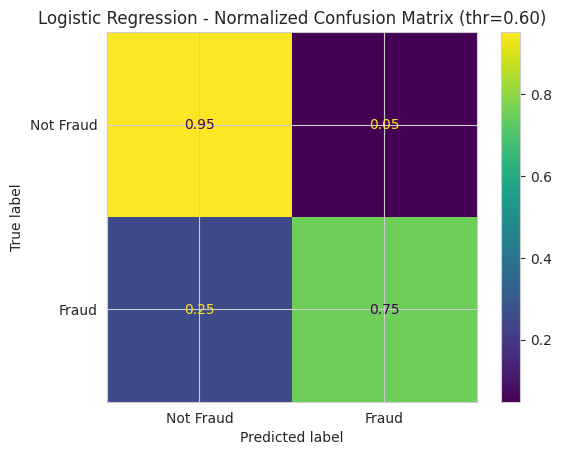

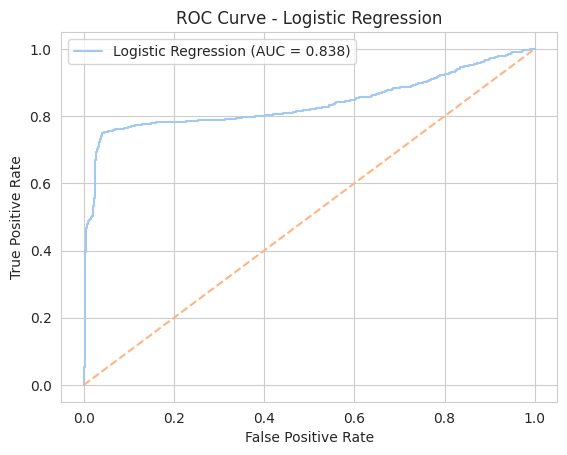

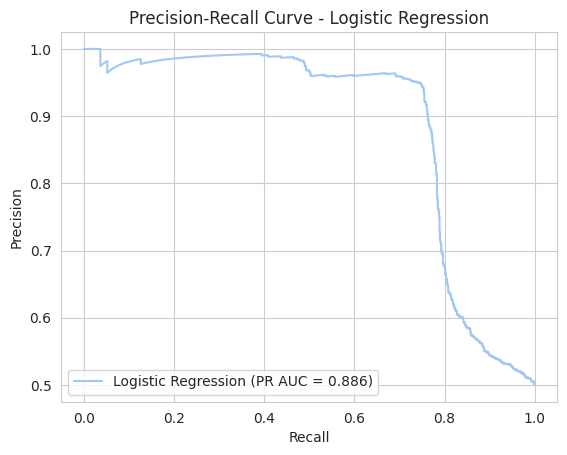

0.8413693346190936


In [32]:
LR_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',   # helpful for fraud / imbalance
    n_jobs=-1,
    random_state=42
)
LR_model.fit(X_train, y_train)

lr_metrics = evaluate_model_with_plots(
    LR_model, X_test, y_test, name="Logistic Regression"
)

LR_accuracy = accuracy_score(y_test, LR_model.predict(X_test))
print(LR_accuracy)

## Decision Tree


===== Decision Tree =====
ROC-AUC: 0.9799
PR-AUC:  0.9837
Avg Precision (AP): 0.9734
Best threshold (by F1): 0.85
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1037
           1       0.98      0.94      0.96      1037

    accuracy                           0.96      2074
   macro avg       0.96      0.96      0.96      2074
weighted avg       0.96      0.96      0.96      2074

Confusion matrix (raw counts):
 [[1018   19]
 [  58  979]]


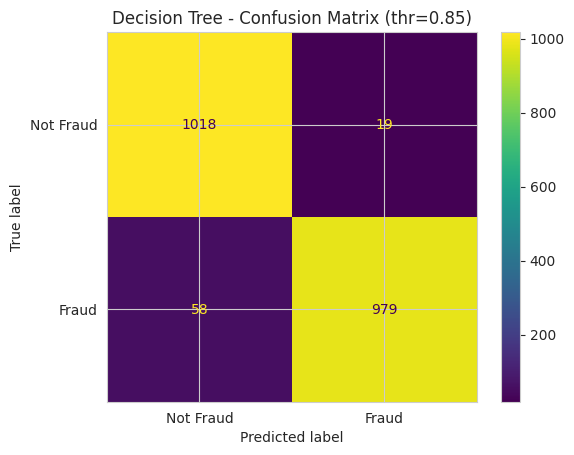

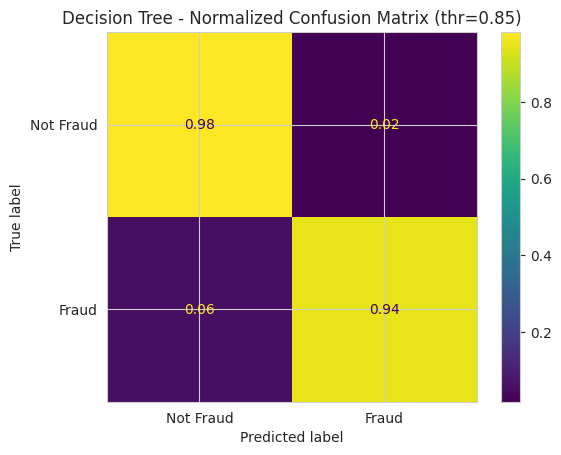

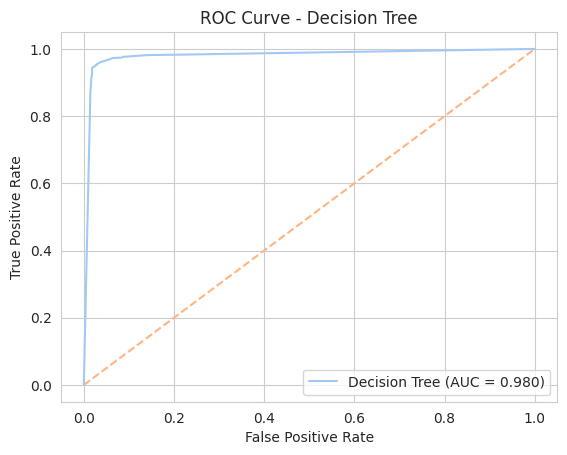

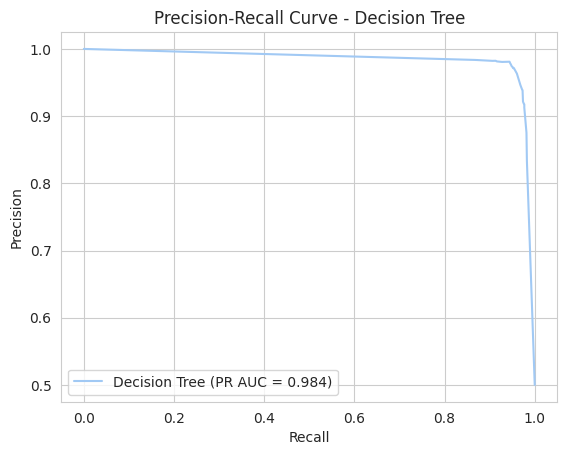

0.9628736740597879


In [33]:
DT_model = DecisionTreeClassifier(
    max_depth=10,          # you can tune this
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
DT_model.fit(X_train, y_train)

dt_metrics = evaluate_model_with_plots(
    DT_model, X_test, y_test, name="Decision Tree"
)

DT_accuracy = accuracy_score(y_test, DT_model.predict(X_test))
print(DT_accuracy)

## Random Forest


===== Random Forest =====
ROC-AUC: 0.9932
PR-AUC:  0.9927
Avg Precision (AP): 0.9927
Best threshold (by F1): 0.50
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1037
           1       0.97      0.96      0.96      1037

    accuracy                           0.96      2074
   macro avg       0.96      0.96      0.96      2074
weighted avg       0.96      0.96      0.96      2074

Confusion matrix (raw counts):
 [[1003   34]
 [  40  997]]


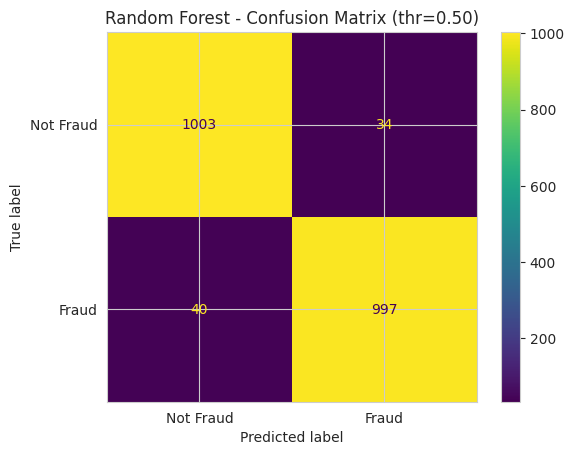

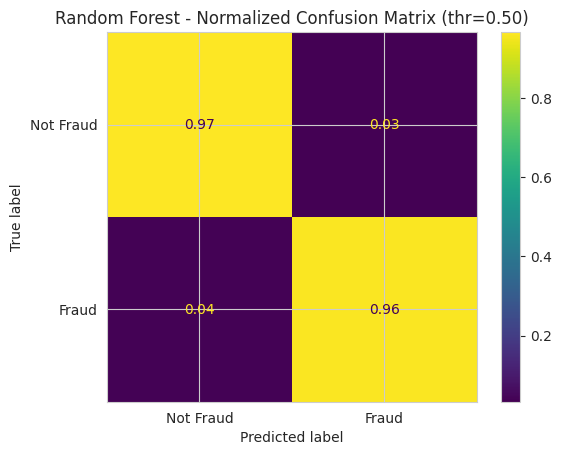

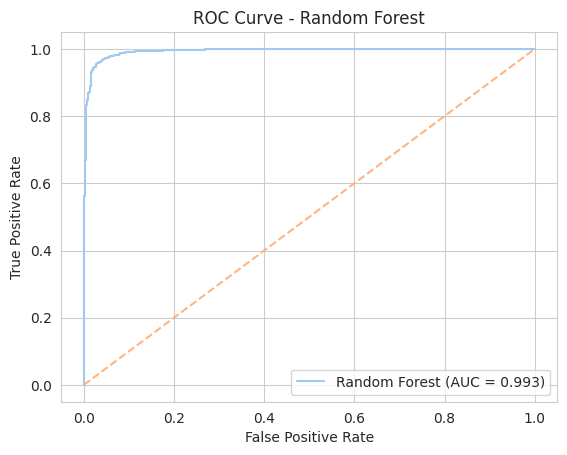

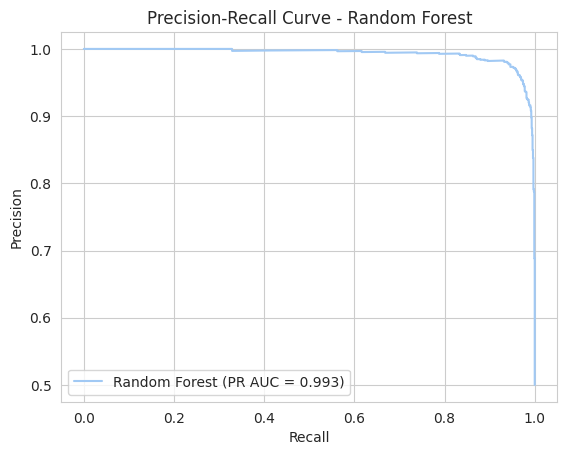

0.9643201542912246


In [34]:
RF_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
RF_model.fit(X_train, y_train)

rf_metrics = evaluate_model_with_plots(
    RF_model, X_test, y_test, name="Random Forest"
)

RF_accuracy = accuracy_score(y_test, RF_model.predict(X_test))
print(RF_accuracy)

Compare results

In [35]:
Algorithms = ['RandomForest', 'Decision Tree', 'Logistic Regression']
accuracy = [RF_accuracy, DT_accuracy, LR_accuracy ]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})

FinalResult

,Algorithm,Accuracy
0,RandomForest,0.964320
1,Decision Tree,0.962874
2,Logistic Regression,0.841369


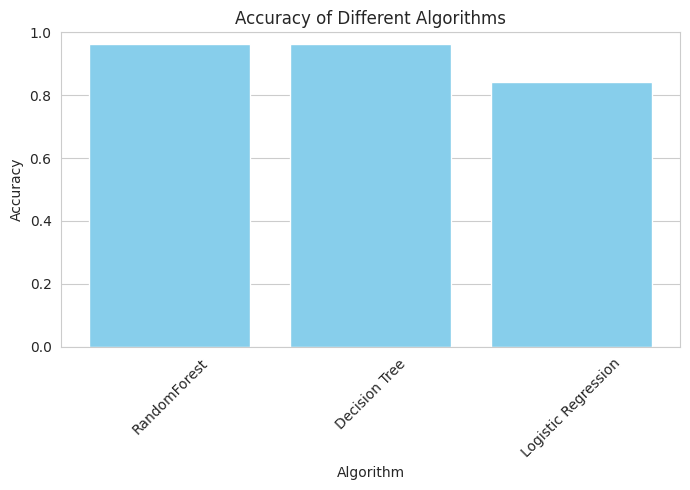

In [36]:
plt.figure(figsize=(7, 5))
plt.bar(FinalResult['Algorithm'], FinalResult['Accuracy'], color='skyblue')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Set the limit of y-axis from 0 to 1 (accuracy ranges from 0 to 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='x')  # Add gridlines only along the x-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# GA FEATURE SELECTION

In [37]:
# Step 1 – Install & import GA tools (DEAP)
!pip install deap
import random
import numpy as np

from deap import base, creator, tools
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.1 MB/s eta 0:00:00


In [38]:
# Step 2 – Define RF evaluator settings
# Number of features (columns) in your current X_train
n_features = X_train.shape[1]

# Random Forest model used as fitness evaluator (can tweak hyperparameters)
rf_evaluator = RandomForestClassifier(
    n_estimators=200,          # keep moderate for speed
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

In [39]:
# Step 3 – Define the fitness function (uses RF + CV + F1)
from sklearn.metrics import make_scorer, f1_score

def evaluate_individual(individual):
    """
    individual: list of 0/1, length = n_features
    Returns: tuple with one element (mean F1 score,)
    """
    # indices of selected features
    selected_idx = [i for i, bit in enumerate(individual) if bit == 1]

    # if no features selected, give worst possible fitness
    if len(selected_idx) == 0:
        return 0.0,

    # subset X_train columns
    X_sub = X_train[:, selected_idx]

    # 3-fold stratified CV using F1 score
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score)

    scores = cross_val_score(
        rf_evaluator,
        X_sub,
        y_train,
        cv=cv,
        scoring=f1_scorer,
        n_jobs=-1
    )

    return scores.mean(),

In [40]:
# Step 4 – Set up the GA (DEAP toolbox)
# Define a "maximize" fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# Individual is just a list with that Fitness
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Gene: 0 or 1
toolbox.register("attr_bool", random.randint, 0, 1)

# Individual: n_features genes
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)

# Population: list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register operators
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [42]:
# Step 5 – Run the Genetic Algorithm
pop_size = 20       # population size
n_gen = 5           # number of generations
cx_prob = 0.7       # crossover probability
mut_prob = 0.2      # mutation probability

# Initialize population
population = toolbox.population(n=pop_size)

print("Starting GA with RF evaluator...")
for gen in range(n_gen):
    print(f"\nGeneration {gen+1}/{n_gen}")

    # Evaluate all individuals
    for ind in population:
        if not ind.fitness.valid:
            ind.fitness.values = toolbox.evaluate(ind)

    # Show best fitness in this generation
    fits = [ind.fitness.values[0] for ind in population]
    print(f"  Best F1 in this generation: {max(fits):.4f}")
    print(f"  Avg F1 in this generation:  {np.mean(fits):.4f}")

    # Selection
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # Crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < cx_prob:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Mutation
    for mutant in offspring:
        if random.random() < mut_prob:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate new individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    for ind in invalid_ind:
        ind.fitness.values = toolbox.evaluate(ind)

    # Replace old population
    population[:] = offspring

print("\nGA finished.")

Starting GA with RF evaluator...

Generation 1/5
  Best F1 in this generation: 0.9672
  Avg F1 in this generation:  0.9060

Generation 2/5
  Best F1 in this generation: 0.9667
  Avg F1 in this generation:  0.9306

Generation 3/5
  Best F1 in this generation: 0.9677
  Avg F1 in this generation:  0.9545

Generation 4/5
  Best F1 in this generation: 0.9677
  Avg F1 in this generation:  0.9623

Generation 5/5
  Best F1 in this generation: 0.9677
  Avg F1 in this generation:  0.9503

GA finished.


In [45]:
# Step 6 – Extract the best feature subset from GA
from deap import tools

# Best individual found by GA
best_ind = tools.selBest(population, 1)[0]
best_f1 = best_ind.fitness.values[0]

print("Best individual (0/1 mask):")
print(best_ind)
print("\nBest cross-validated F1 (RF evaluator):", best_f1)

# Indices of selected features
selected_idx = [i for i, bit in enumerate(best_ind) if bit == 1]
print("\nNumber of selected features:", len(selected_idx))
print("Selected feature indices:", selected_idx)

Best individual (0/1 mask):
[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]

Best cross-validated F1 (RF evaluator): 0.9677418360008043

Number of selected features: 6
Selected feature indices: [0, 1, 4, 5, 11, 13]


In [50]:
# Step 7 – Train your final models on GA-selected features
X_train_ga = X_train[:, selected_idx]
X_test_ga  = X_test[:, selected_idx]

Logistic Regression


===== GA-Selected Logistic Regression =====
ROC-AUC: 0.8216
PR-AUC:  0.8771
Avg Precision (AP): 0.8772
Best threshold (by F1): 0.65
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1037
           1       0.95      0.75      0.84      1037

    accuracy                           0.86      2074
   macro avg       0.87      0.86      0.85      2074
weighted avg       0.87      0.86      0.85      2074

Confusion matrix (raw counts):
 [[992  45]
 [255 782]]


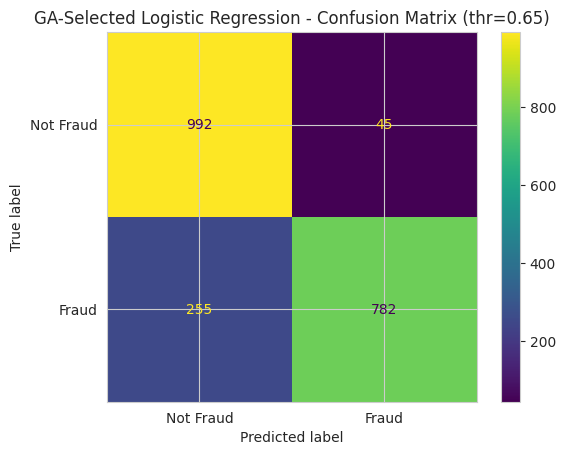

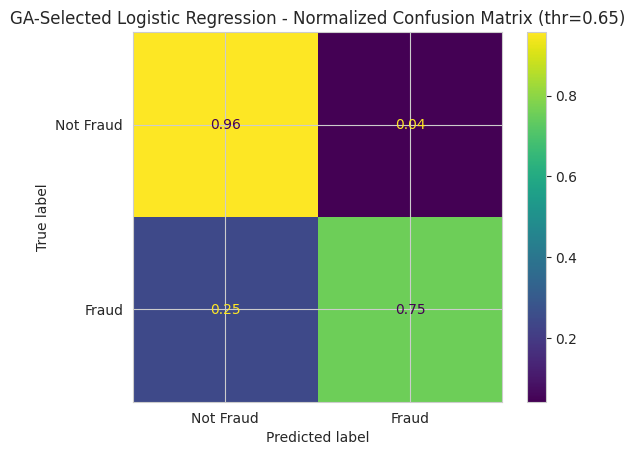

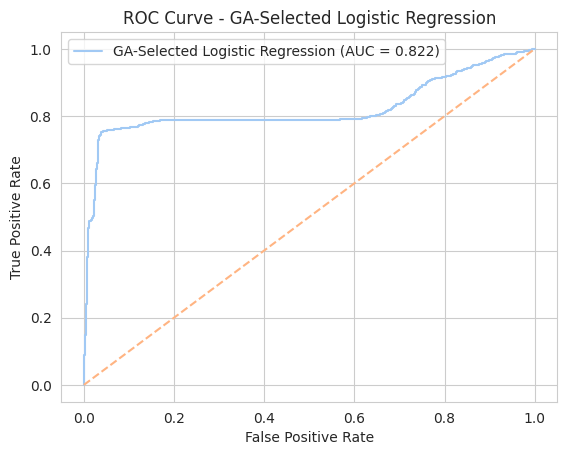

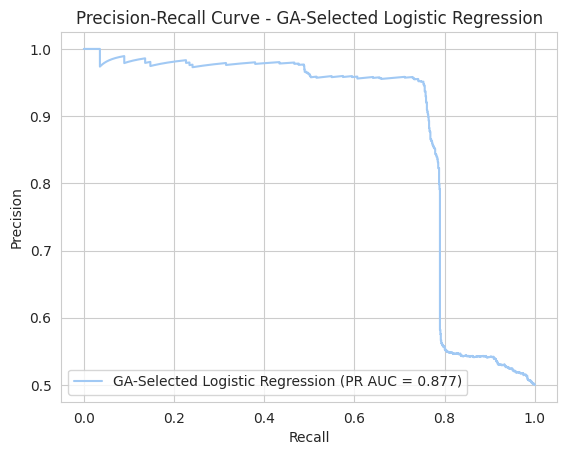

In [55]:
# Logistic Regression with GA-selected features
LR_model_ga = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
LR_model_ga.fit(X_train_ga, y_train)

lr_ga_metrics = evaluate_model_with_plots(LR_model_ga, X_test_ga, y_test, name="GA-Selected Logistic Regression")

Decision Tree


===== GA-Selected Decision Tree =====
ROC-AUC: 0.9826
PR-AUC:  0.9855
Avg Precision (AP): 0.9761
Best threshold (by F1): 0.50
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1037
           1       0.97      0.96      0.97      1037

    accuracy                           0.97      2074
   macro avg       0.97      0.97      0.97      2074
weighted avg       0.97      0.97      0.97      2074

Confusion matrix (raw counts):
 [[1008   29]
 [  38  999]]


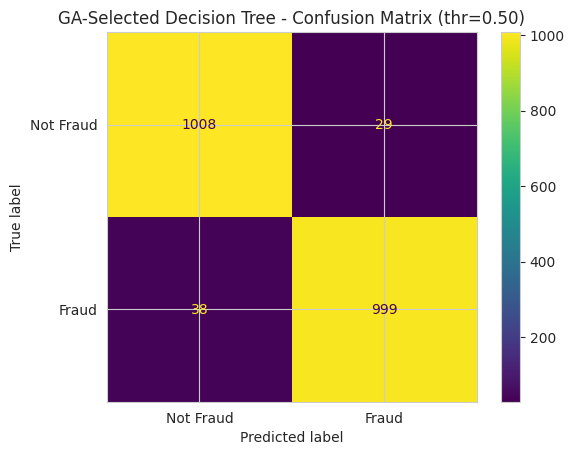

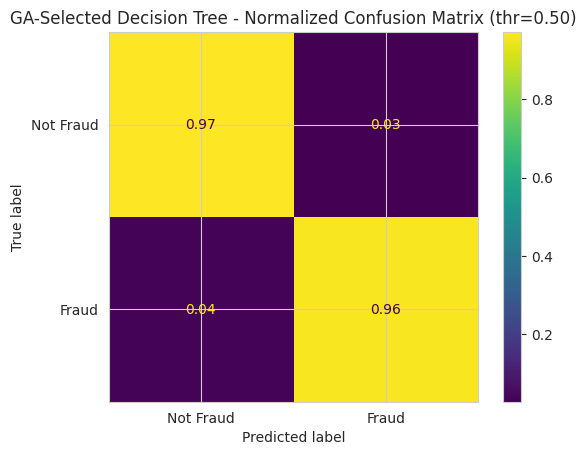

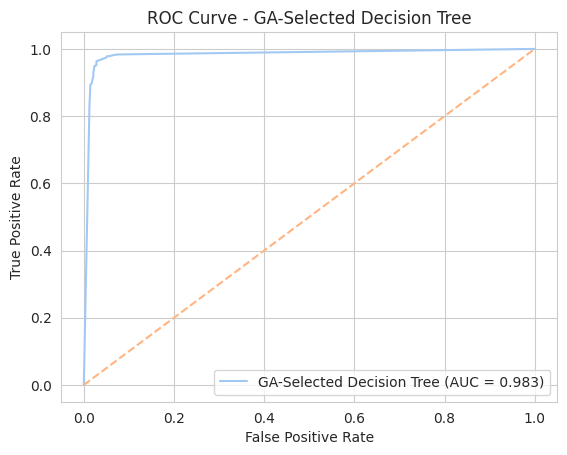

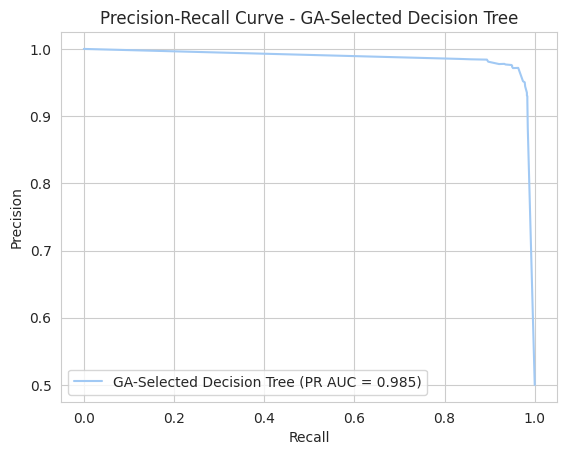

In [56]:
# Decision Tree with GA-selected features
DT_model_ga = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
DT_model_ga.fit(X_train_ga, y_train)

dt_ga_metrics = evaluate_model_with_plots(DT_model_ga, X_test_ga, y_test, name="GA-Selected Decision Tree")

Random Forest


===== GA-Selected Random Forest =====
ROC-AUC: 0.9943
PR-AUC:  0.9934
Avg Precision (AP): 0.9934
Best threshold (by F1): 0.50
Classification report at best threshold:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1037
           1       0.97      0.96      0.97      1037

    accuracy                           0.97      2074
   macro avg       0.97      0.97      0.97      2074
weighted avg       0.97      0.97      0.97      2074

Confusion matrix (raw counts):
 [[1008   29]
 [  37 1000]]


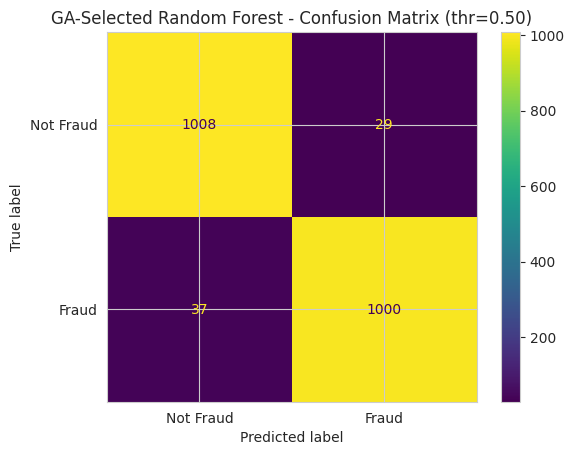

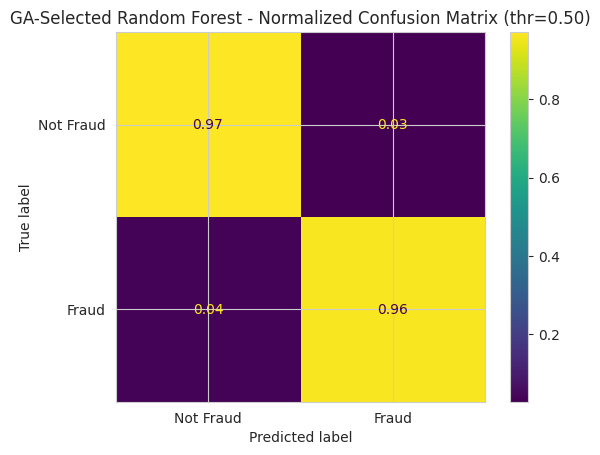

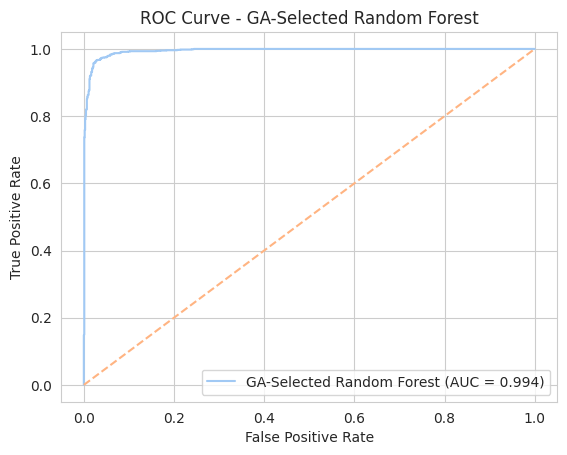

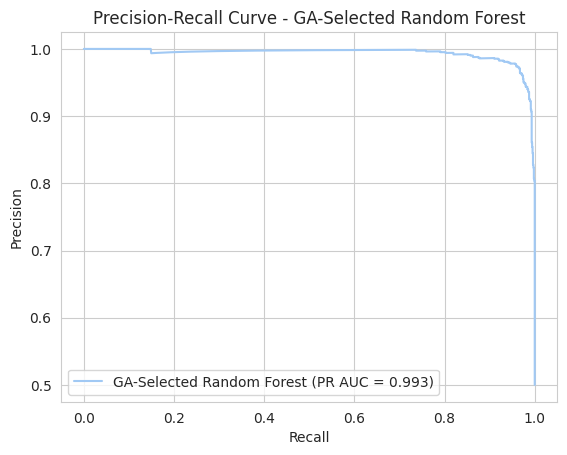

In [57]:
# Random Forest with GA-selected features
RF_model_ga = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
RF_model_ga.fit(X_train_ga, y_train)

rf_ga_metrics = evaluate_model_with_plots(RF_model_ga, X_test_ga, y_test, name="GA-Selected Random Forest")

In [58]:
import pandas as pd
from sklearn.metrics import accuracy_score

def get_accuracy(model, X_test, y_test, threshold=None):
    """
    If threshold is given, use it to binarize probabilities.
    Otherwise, use model.predict().
    """
    if threshold is not None and hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

rows = []

# ------------ Logistic Regression ------------
# Before GA
acc_lr_before = get_accuracy(LR_model, X_test, y_test, threshold=lr_metrics["best_threshold"])
rows.append({
    "Model": "LR",
    "Phase": "Before GA",
    "F1": lr_metrics["best_f1"],
    "ROC_AUC": lr_metrics["roc_auc"],
    "PR_AUC": lr_metrics["pr_auc"],
    "Accuracy": acc_lr_before
})

# After GA
acc_lr_after = get_accuracy(LR_model_ga, X_test_ga, y_test, threshold=lr_ga_metrics["best_threshold"])
rows.append({
    "Model": "LR",
    "Phase": "After GA",
    "F1": lr_ga_metrics["best_f1"],
    "ROC_AUC": lr_ga_metrics["roc_auc"],
    "PR_AUC": lr_ga_metrics["pr_auc"],
    "Accuracy": acc_lr_after
})

# ------------ Random Forest ------------
acc_rf_before = get_accuracy(RF_model, X_test, y_test, threshold=rf_metrics["best_threshold"])
rows.append({
    "Model": "RF",
    "Phase": "Before GA",
    "F1": rf_metrics["best_f1"],
    "ROC_AUC": rf_metrics["roc_auc"],
    "PR_AUC": rf_metrics["pr_auc"],
    "Accuracy": acc_rf_before
})

acc_rf_after = get_accuracy(RF_model_ga, X_test_ga, y_test, threshold=rf_ga_metrics["best_threshold"])
rows.append({
    "Model": "RF",
    "Phase": "After GA",
    "F1": rf_ga_metrics["best_f1"],
    "ROC_AUC": rf_ga_metrics["roc_auc"],
    "PR_AUC": rf_ga_metrics["pr_auc"],
    "Accuracy": acc_rf_after
})

# ------------ Decision Tree ------------
acc_dt_before = get_accuracy(DT_model, X_test, y_test, threshold=dt_metrics["best_threshold"])
rows.append({
    "Model": "DT",
    "Phase": "Before GA",
    "F1": dt_metrics["best_f1"],
    "ROC_AUC": dt_metrics["roc_auc"],
    "PR_AUC": dt_metrics["pr_auc"],
    "Accuracy": acc_dt_before
})

acc_dt_after = get_accuracy(DT_model_ga, X_test_ga, y_test, threshold=dt_ga_metrics["best_threshold"])
rows.append({
    "Model": "DT",
    "Phase": "After GA",
    "F1": dt_ga_metrics["best_f1"],
    "ROC_AUC": dt_ga_metrics["roc_auc"],
    "PR_AUC": dt_ga_metrics["pr_auc"],
    "Accuracy": acc_dt_after
})

results_df = pd.DataFrame(rows)
print(results_df)

  Model      Phase        F1   ROC_AUC    PR_AUC  Accuracy
0    LR  Before GA  0.836188  0.837749  0.886304  0.852459
1    LR   After GA  0.839056  0.821575  0.877116  0.855352
2    RF  Before GA  0.964217  0.993164  0.992744  0.964320
3    RF   After GA  0.968054  0.994297  0.993395  0.968177
4    DT  Before GA  0.962162  0.979939  0.983693  0.962874
5    DT   After GA  0.967554  0.982623  0.985470  0.967695
